## Tutorial 3: Computed Tomography

Continuing our exposition on the applications of Fourier transform, today, we are going to understand computed tomography (CT) which is an imaging method that enabled several imaging applications, for e.g. X-ray CT scanning

Agenda:
- Radon transform
- Sinogram
- Back projection (BP)
- Draw-backs of doing BP
- Slice-projection theorem
- Filtered back-projection
- Practical considerations: doing CT using convolution
- How is the reconstruction done today? patch-based priors, CNNs
- Today's CT scanners: fan-beam CT, cone-beam CT, spectral CT
- Hough transform 
    - detecting circles or lines in an image

## Physics of X-ray CT

According to Beer-Lambert's law of light attenuation, the measured intensity of light is given by

$$
I(x) = I_0 \text{exp}(- \int_{R} f(x, y) dy)
$$

where $I_0$ is the emitted light intensity. Taking the logarithm yields

$$
p(x) = -\text{log} \frac{I(x)}{I_0} = \int_{R} f(x, y) dy = \mathcal{P} f
$$



<video controls src="ct-at-max-speed.mp4" />



In [194]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import misc

Let $I(x,y)$ be our 2D object of interest that we desire to scan using our X-ray CT machine. 

Let us define a line parametrixed by $(\theta, s)$ to be

$$
xcos(\theta) + ysin(\theta) = s
$$

<img src="line.png" width="360">

We desire to scan our object of interest using a parallel beam of X-rays.

<img src="object-scan.png" width="360">



## Radon transform

In the above shown scan each line for each $\theta$ there are parallel rays with different $s$ that are emitted simultaneously. What we obtain at the other end is called the _absorption_ profile of the tissue. Here, since our body is pixelized, the aborption profile is nothing but the sum of the pixels along a chosen specific line. In the continous case, it is the _line integral_ along a chosen line of scanning. 

To get the value of each point in the absorption profile, we just need to calculate the line-integral along the chosen line, we can formalize this as follows:

$$
g (s, \theta) = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} I(x,y) \delta (xcos(\theta) + ysin(\theta) - s) dx dy
$$

This is called **the Radon transform**

Now, let us see how to implement this.

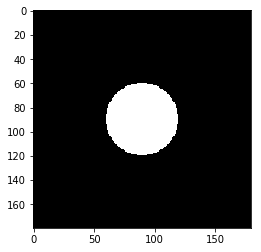

In [195]:
# Let us first create a phantom that we would like to scan
# for simplicity we will consider a circular phantom
# In this block we are creating a 256x256 image with a cricle of radius 50

N = 180
x_start, x_end = -90, 90
y_start, y_end = -90, 90

x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)

x0, y0, radius = 0.0, 0.0, 30

x, y = np.meshgrid(x, y)
r = np.sqrt((x - x0)**2 + (y - y0)**2)

outside = r > radius

circle = np.ones([N, N])
circle[outside] = 0

plt.imshow(circle, cmap='gray')
plt.show()

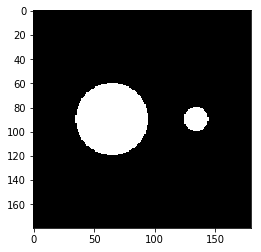

In [196]:
## Let's create a slightly complex phantom consisting of two circles

N = 180
x_start, x_end = -90, 90
y_start, y_end = -90, 90

two_circles = np.zeros([N, N])

x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)

x0_1, y0_1, radius_1 = -25, 0.0, 30

x, y = np.meshgrid(x, y)
r_1 = np.sqrt((x - x0_1)**2 + (y - y0_1)**2)

inside_1 = r_1 <= radius_1

two_circles[inside_1] = 1

x0_2, y0_2, radius_2 = 45, 0.0, 10

#x, y = np.meshgrid(x, y)
r_2 = np.sqrt((x - x0_2)**2 + (y - y0_2)**2)

inside_2 = r_2 <= radius_2

#print(np.where(inside_2==True))
two_circles[inside_2] = 1


plt.imshow(two_circles, cmap='gray')
plt.show()

In [197]:
def radon_transform(image, steps, mode="steps"):
    if mode=="angle":
        #radon = np.zeros(1, len(image), dtype='float64')
        rotation = misc.imrotate(image, steps).astype('float64')
        radon = sum(rotation)
        return radon
    elif mode=="steps":
        radon = np.zeros((steps, len(image)), dtype='float64')
        for s in range(steps):
            #print(s*180/steps)
            rotation = misc.imrotate(image, -s*180/steps).astype('float64')
            radon[:,s] = sum(rotation)
        return radon
    else:
        print("Unknown mode given in the argument of radon transform")
        return 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  after removing the cwd from sys.path.


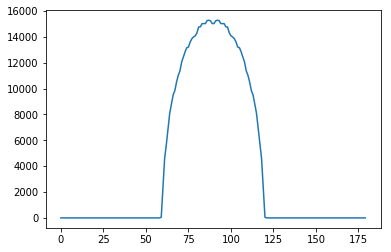

In [224]:
plt.plot(radon_transform(circle, 100,"angle"))
plt.show()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  after removing the cwd from sys.path.


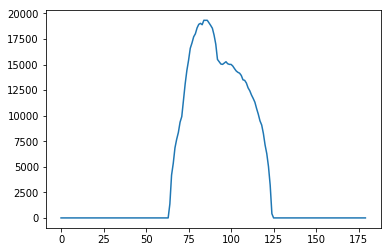

In [226]:
plt.plot(radon_transform(two_circles, 100,"angle"))
plt.show()

Now let us collect the radon transform along many different angles. 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  # This is added back by InteractiveShellApp.init_path()


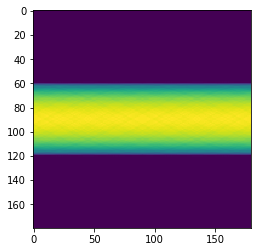

In [200]:
rt_circles = radon_transform(circle, circle.shape[0], "steps")
plt.imshow(rt_circles)
plt.show()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  # This is added back by InteractiveShellApp.init_path()


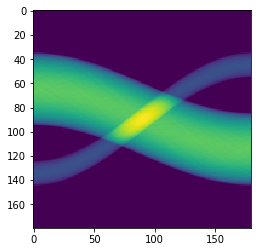

In [201]:
rt_two_circles = radon_transform(two_circles,180, "steps")
plt.imshow(rt_two_circles)
plt.show()

The above image is called the *sinogram* 

Say we have the values of $g(s,\theta)$ for the angles $\{\theta_k\}$ between $0$ and $\pi$. For a fixed value of $g(s,\theta)$, just copy this value into the image along the corresponding line $xcos(\theta) + ysin(\theta) = s$

$$
F_\theta (x,y) = g(xcos(\theta)+ysin(\theta), 0)
$$


Let us just reconstruct the sum of back-projections which is:

$$
\sum_{\theta=0}^{\pi} F_\theta (x, y)
$$

This summation image is called as the *laminogram*


<img src="back-projection-intuition.png" width="360">



[  0.          59.66666667 119.33333333 179.        ]


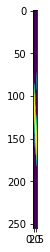

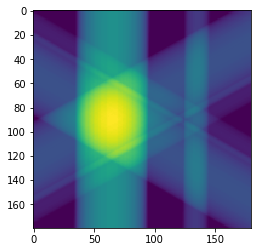

In [204]:
from skimage.transform import iradon,radon

angles = np.linspace(start=0,stop=179,num=180)
angles_chosen = np.linspace(start=0,stop=179,num=4)
print(angles_chosen)
idx = np.round(angles_chosen).astype(int)

sinogram = radon(two_circles,angles[idx])
plt.imshow(sinogram)
img = iradon(sinogram,angles[idx],filter=None)
plt.subplots()
plt.imshow(img)

If we look at the images of the laminograms shown above, we can notice that if we get smeared borders and that the content leaks out of the borders. How do we fix this? 

In order to get to this, let us first understand what Slice-Projection theorem is.

## Slice-Projection Theorem

Let us consider the Fourier transform of the projection $p_\theta (s)$, we will call it ${P}(\xi, \theta)$

previously, we have seen that 

$$
P (\xi, \theta) = \int_{-\infty}^{\infty} p_\theta(s) e^{-2\pi i \xi s} ds
$$

If we substitute the value of $p_\theta (s)$ from the Radon transform we get the following

$$
P (\xi, \theta) = \int_{-\infty}^{\infty} \int \int_{-\infty}^{\infty} f(x, y) \delta(x cos\theta + y sin\theta - s) dx dy e^{-2\pi i \xi s} ds
$$

By rearranging the integrals we get:
$$
P (\xi, \theta) = \int \int_{-\infty}^{\infty} f(x, y) \int_{-\infty}^{\infty} \delta(x cos\theta + y sin\theta - s) e^{-2\pi i \xi s} ds dx dy 
$$

If we consider the inner integral, the delta function shoots only when $x cos \theta + y sin \theta = s$, so upon just substituting the value of $s$

$$
P (\xi, \theta) = \int \int_{-\infty}^{\infty} f(x, y) e^{-2\pi i \xi (x cos \theta + y sin \theta)} dx dy
$$

which is 

$$
P (\xi, \theta) = \left. \int \int_{-\infty}^{\infty} f(x, y) e^{-2\pi i  (x u + y v)} \right\Vert_{u = \xi cos\theta, v = \xi sin \theta} dx dy
$$

which finally results in the following Slice-Projection theorem

$$
P (\xi, \theta) = F(\xi cos \theta, \xi sin \theta) = F_{polar} (\xi, \theta)
$$

In effect, we can get the complete Fourier transform $F_{polar} (\xi, \theta)$ of the unknown function $f(x,y)$ in polar coordinates $(\xi, \theta)$ by varying $\theta$, i.e., we can reconstruct the Fourier transform of the image that we plan to recover just by collecting the 1D projections (and thereby, their Fourier transforms) from all the possible $\theta$'s


<img src="slice-projection.png" width="640">


## Filtered Back Projection

The Fourier transform of the desired object $f(x, y)$ can be written as 

$$
f(x, y) = \int \int_{-\infty}^{\infty} F(u, v) e^{-2 \pi i (ux + vy)} du dv
$$

Since we would like the Fourier transform to be parametrized in the  to $\xi, \theta$ i.e. $u, v = \xi cos\theta, \xi sin\theta$, 

in order to change the integration variables: 


\begin{aligned}
du &= cos\theta d\xi  - \xi sin\theta d\theta\\
dv &= sin\theta d\xi  + \xi cos\theta d\theta
\end{aligned}

$$
\begin{bmatrix}
    du \\
    dv
\end{bmatrix}
= \begin{bmatrix}
    cos \theta & -\xi sin \theta \\
    sin \theta &  \xi cos \theta
\end{bmatrix}
\begin{bmatrix}
    d\xi \\
    d\theta
\end{bmatrix}
$$

if we think of an area element using which we integrate the $x-y$ space, i.e., $dx dy$, then if we would like to convert to $ d\xi d\theta$ then we must conserve the area of the area element that we are integrating with, i.e., we would have to scale it by the $\text{det}(\text{Jacobian})$ matrix above i.e., by $|\xi|$

By this, we obtain:

$$
f(x, y) = \int_{0}^{\pi} \int_{-\infty}^{\infty} F_{\text{polar}}(\xi, \theta) |\xi| e^{-2 \pi i \xi(x cos \theta + y sin \theta)} d\xi d\theta
$$


<img src="correction-filters.png" width="640">


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.]


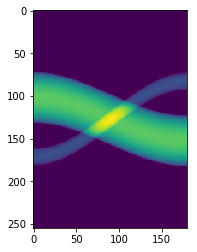

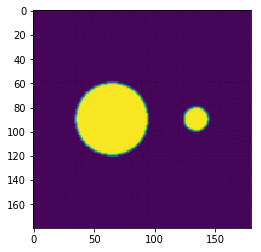

In [213]:
angles = np.linspace(start=0,stop=179,num=180)
angles_chosen = np.linspace(start=0,stop=179,num=180)
print(angles_chosen)
idx = np.round(angles_chosen).astype(int)

sinogram = radon(two_circles,angles[idx])
plt.imshow(sinogram)
img = iradon(sinogram,angles[idx],filter="shepp-logan")
plt.subplots()
plt.imshow(img)

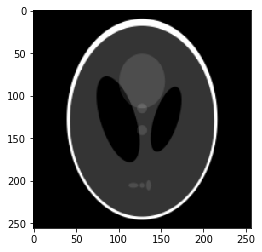

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.]


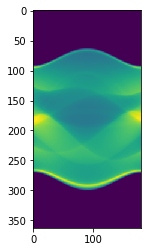

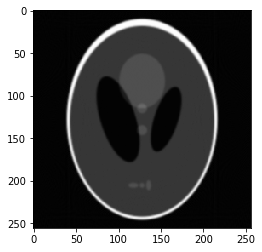

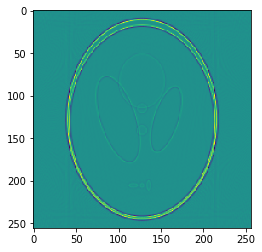

In [233]:
# Let us look at slightly complicated images.
import cv2
shepplogan_phantom = cv2.imread('shepplogan.png',cv2.IMREAD_GRAYSCALE).astype(float)/255.0
shepplogan_phantom = cv2.resize(shepplogan_phantom, (256,256))
plt.subplots()
plt.imshow(shepplogan_phantom, cmap = 'gray')
plt.show()

angles = np.linspace(start=0,stop=179,num=180)
angles_chosen = np.linspace(start=0,stop=179,num=180)
print(angles_chosen)
idx = np.round(angles_chosen).astype(int)

sinogram = radon(shepplogan_phantom,angles[idx])
plt.imshow(sinogram)
img = iradon(sinogram,angles[idx],filter="shepp-logan") # "shepp-logan", "ramp"

plt.subplots()
plt.imshow(img, cmap='gray')


plt.subplots()
plt.imshow(shepplogan_phantom-img)
plt.show()

What can we observe from above image? We can observe that all the low frequencies are reconstructed properly but not the high frequencies. Reason?


<img src="radial-sampling.png" width="360">


In CT we are basically reconstructing from radially undersampled 2D Fourier transform of an image, where rate depends upon  the number of projections used. So, if we don't sample finely enough, the frequencies that are closer to origin, i.e., the low-frequencies get finely sampled but the high-frequencies are sampled sparsely. Hence, we lose high-frequency content in the reconstructed image.

## Convolution version of the ramp filter

The Filtered Back Projection algorithm gives us:

$$
f(x, y) = \int_{0}^{\pi} \int_{-\infty}^{\infty} F_{\text{polar}}(\xi, \theta) |\xi| e^{-2 \pi i \xi(x cos \theta + y sin \theta)} d\xi d\theta
$$

What does the above equation say? Basically it asks us to calculate the Fourier transform of each projection and multiply it by a filter which is similar to the filters shown above. So, we can simply convert the above equation into spatial domain, then it is represented as follows:

$$
f(x, y) = \int_{0}^{\pi} \left. p_\theta(s) \ast h(s) \right \Vert_{s = x cos\theta + ysin \theta} d\theta
$$


<img src="freq-spatial-filters.png" width="640">


In most of the real life scenarios, the FBP is implemented this way.

## Different Acquisition Geometries

- Fan-beam CT
- Cone-beam CT

<img src="fan-and-cone-beam.png" width="640">



## CT as an inverse problem

A second approach to CT image reconstruction defines the problem as a system
of linear equations. Each projection ray corresponds to a linear equation
that sums up the image pixels the ray passes through, i. e., computes its discrete
line integral, and demands it to equal the measured line integral value.

$$
\mathbf{A} \mathbf{x} = \mathbf{p}
$$

where $\mathbf{x}$ is the object we are scanning/the ideal image and $\mathbf{p}$ is the projections that we obtain. $\mathbf{A}$ describes how each pixel contributed to a particular ray. In the simplest case, we the elements of $\mathbf{A}$ will contain $1$ if the pixel contributed to the projection and $0$, if not. 

Illustrated below:

<img src="pixel_proj_contrib.png" width="480">

This problem is heavily ill-posed because there can be many possible $\mathbf{x}$ that satisfy the above equation. But the good news is we can use our domain knowledge induce priors on the reconstructed image.


Even for decently sized images, we cannot invert the matrix $\mathbf{A}$ in our life-time with the amount of compute we have at hand. Rather, we choose to solve the following optimization problem:

$$
\arg \min_{\mathbf{x}} ||\mathbf{A} \mathbf{x} - \mathbf{p}||_2^2
$$

In the coming classes, we will see that such problems are common in most of the image processing tasks and we will discuss then how to solve such problems. 

This formulation of the problem also helps us to induce priors on the reconstructed/scanned image $\mathbf{x}$. Commonly used priors in this problems are total variation, sparse priors (on the Laplacian/edges image) and recently, convolutional neural networks.

## Hough transform

Very similar in spirit to Radon transform is the Hough transform. 

We can consider each point of the source image and generate all possible $(\rho, \theta)$ combinations that are possible for each point in an image. 

(100, 100)


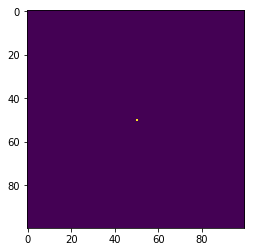

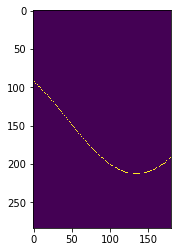

In [252]:
import numpy as np
from skimage.transform import hough_line

single_point = np.zeros((100, 100)).astype(np.uint8)
single_point[50,50] = 1.0

ht_single_point = hough_line(single_point)
plt.subplots()
plt.imshow(single_point)
plt.show()

plt.subplots()
plt.imshow(ht_single_point[0])
plt.show()

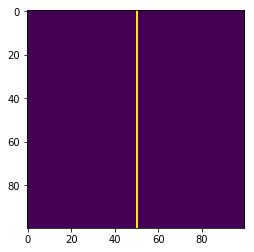

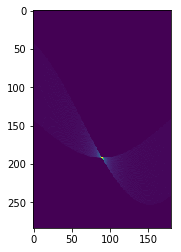

In [253]:
single_line =  np.zeros((100, 100)).astype(np.uint8)
single_line[:,50] = 1.0

ht_single_line = hough_line(single_line)
plt.subplots()
plt.imshow(single_line)
plt.show()

plt.subplots()
plt.imshow(ht_single_line[0])
plt.show()

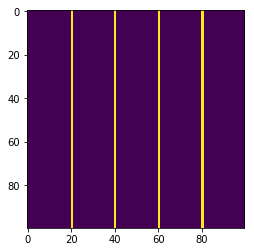

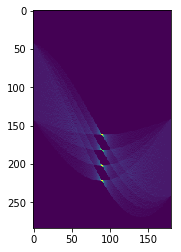

In [256]:
parallel_lines =  np.zeros((100, 100)).astype(np.uint8)
parallel_lines[:,20] = 1.0
parallel_lines[:,40] = 1.0
parallel_lines[:,60] = 1.0
parallel_lines[:,80] = 1.0

ht_parallel_lines = hough_line(parallel_lines)
plt.subplots()
plt.imshow(parallel_lines)
plt.show()

plt.subplots()
plt.imshow(ht_parallel_lines[0])

plt.show()

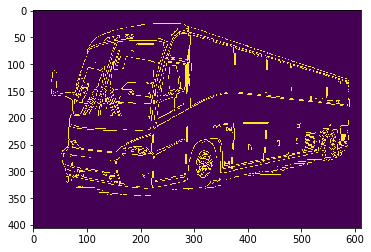

In [286]:
bus = cv2.imread('bus.jpg',cv2.IMREAD_GRAYSCALE).astype(np.uint8)
# Note: it is important to work with the edge images prior to doing Hough transform 
canny_bus = cv2.Canny(bus,50,150,apertureSize = 3)
plt.subplots()
plt.imshow(canny_bus)

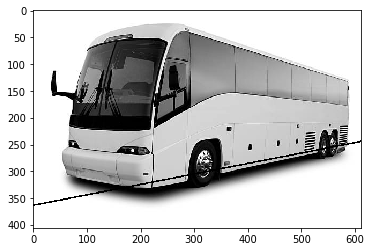

In [289]:
lines_bus = cv2.HoughLines(canny_bus,1,np.pi/180,200)
sudoku_prior = sudoku
#print(lines_sudoku)
for rho,theta in lines_bus[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(bus,(x1,y1),(x2,y2),(0,255,255),2)

cv2.imwrite('hough-bus.jpg', bus)
plt.imshow(bus,cmap='gray')

Similarly, Hough transform can also be extended for detecting other shapes such as, circles, ellipses etc. Just we need to find a way to parametrize them accordingly.